# Spatial Analysis and Modeling

### Instructor: Rossano Schifanella
Email: [rossano.schifanella@unito.it](mailto:rossano.schifanella@unito.it)

This tutorial has been adapted from the teaching material for the geospatial data analysis tutorial
at [GeoPython 2018](http://2018.geopython.net), May 7-9 2018, Basel, Switzerland, and was later updated and also
used at [Scipy 2018](https://scipy2018.scipy.org/) and [EuroScipy 2018](https://www.euroscipy.org/2018/).

The original material has been created by [**Joris Van den Bossche**](https://github.com/jorisvandenbossche) and it can be downloaded [here](https://github.com/jorisvandenbossche/geopandas-tutorial).

# Spatial joins

Goals of this notebook:

- Based on the `countries` and `cities` dataframes, determine for each city the country in which it is located.
- To solve this problem, we will use the the concept of a 'spatial join' operation: combining information of geospatial datasets based on their spatial relationship.

In [25]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import pandas as pd
import geopandas

pd.options.display.max_rows = 10

In [26]:
countries = geopandas.read_file("zip://./data/ne_110m_admin_0_countries.zip")
cities = geopandas.read_file("zip://./data/ne_110m_populated_places.zip")
rivers = geopandas.read_file("zip://./data/ne_50m_rivers_lake_centerlines.zip")

## Recap - joining dataframes

Pandas provides functionality to join or merge dataframes in different ways, see https://chrisalbon.com/python/data_wrangling/pandas_join_merge_dataframe/ for an overview and https://pandas.pydata.org/pandas-docs/stable/merging.html for the full documentation.

To illustrate the concept of joining the information of two dataframes with pandas, let's take a small subset of our `cities` and `countries` datasets: 

In [27]:
cities2 = cities[cities['name'].isin(['Bern', 'Brussels', 'London', 'Paris'])].copy()
cities2['iso_a3'] = ['CHE', 'BEL', 'GBR', 'FRA']

In [28]:
cities2

name                   geometry iso_a3
26       Bern   POINT (7.46698 46.91668)    CHE
170  Brussels   POINT (4.33137 50.83526)    BEL
219    London  POINT (-0.11867 51.50194)    GBR
235     Paris   POINT (2.33139 48.86864)    FRA

In [29]:
countries2 = countries[['iso_a3', 'name', 'continent']]
countries2.head()

iso_a3                  name      continent
0    AFG           Afghanistan           Asia
1    AGO                Angola         Africa
2    ALB               Albania         Europe
3    ARE  United Arab Emirates           Asia
4    ARG             Argentina  South America

We added a 'iso_a3' column to the `cities` dataset, indicating a code of the country of the city. This country code is also present in the `countries` dataset, which allows us to merge those two dataframes based on the common column.

Joining the `cities` dataframe with `countries` will transfer extra information about the countries (the full name, the continent) to the `cities` dataframe, based on a common key:

In [30]:
cities2.merge(countries2, on='iso_a3')

name_x                   geometry iso_a3          name_y continent
0      Bern   POINT (7.46698 46.91668)    CHE     Switzerland    Europe
1  Brussels   POINT (4.33137 50.83526)    BEL         Belgium    Europe
2    London  POINT (-0.11867 51.50194)    GBR  United Kingdom    Europe
3     Paris   POINT (2.33139 48.86864)    FRA          France    Europe

**But**, for this illustrative example, we added the common column manually, it is not present in the original dataset. However, we can still know how to join those two datasets based on their spatial coordinates.

## Recap - spatial relationships between objects

In the previous notebook [02-spatial-relationships.ipynb](./02-spatial-relationships-operations.ipynb), we have seen the notion of spatial relationships between geometry objects: within, contains, intersects, ...

In this case, we know that each of the cities is located *within* one of the countries, or the other way around that each country can *contain* multiple cities.

We can test such relationships using the methods we have seen in the previous notebook:

In [31]:
france = countries.loc[countries['name'] == 'France', 'geometry'].squeeze()

In [32]:
cities.within(france)

0      False
1      False
2      False
3      False
4      False
       ...  
238    False
239    False
240    False
241    False
242    False
Length: 243, dtype: bool

The above gives us a boolean series, indicating for each point in our `cities` dataframe whether it is located within the area of France or not.  
Because this is a boolean series as result, we can use it to filter the original dataframe to only show those cities that are actually within France:

In [33]:
cities[cities.within(france)]

name                  geometry
10    Monaco  POINT (7.40691 43.73965)
13   Andorra  POINT (1.51649 42.50000)
186   Geneva  POINT (6.14003 46.21001)
235    Paris  POINT (2.33139 48.86864)

We could now repeat the above analysis for each of the countries, and add a column to the `cities` dataframe indicating this country. However, that would be tedious to do manually, and is also exactly what the spatial join operation provides us.

*(note: the above result is incorrect, but this is just because of the coarse-ness of the countries dataset)*

## Spatial join operation

<div class="alert alert-info" style="font-size:120%">
<b>SPATIAL JOIN</b> = *transferring attributes from one layer to another based on their spatial relationship* <br><br>


Different parts of this operations:

<ul>
  <li>The GeoDataFrame to which we want add information</li>
  <li>The GeoDataFrame that contains the information we want to add </li>
  <li>The spatial relationship we want to use to match both datasets ('intersects', 'contains', 'within')</li>
  <li>The type of join: left or inner join</li>
</ul>

</div>

In this case, we want to join the `cities` dataframe with the information of the `countries` dataframe, based on the spatial relationship between both datasets.

We use the [`geopandas.sjoin`](http://geopandas.readthedocs.io/en/latest/reference/geopandas.sjoin.html) function:

In [34]:
joined = geopandas.sjoin(cities, countries, op='within', how='left')

In [35]:
joined

name_left                     geometry  index_right iso_a3  \
0      Vatican City    POINT (12.45339 41.90328)         79.0    ITA   
1        San Marino    POINT (12.44177 43.93610)         79.0    ITA   
2             Vaduz     POINT (9.51667 47.13372)          9.0    AUT   
3           Lobamba   POINT (31.20000 -26.46667)        152.0    SWZ   
4        Luxembourg     POINT (6.13000 49.61166)         97.0    LUX   
..              ...                          ...          ...    ...   
238  Rio de Janeiro  POINT (-43.22697 -22.92308)         22.0    BRA   
239       São Paulo  POINT (-46.62697 -23.55673)         22.0    BRA   
240          Sydney  POINT (151.18323 -33.91807)          8.0    AUS   
241       Singapore    POINT (103.85387 1.29498)        111.0    MYS   
242       Hong Kong   POINT (114.18306 22.30693)         30.0    CHN   

     name_right      continent       pop_est  gdp_md_est  
0         Italy         Europe  6.213780e+07   2221000.0  
1         Italy         Europe  6.213780e+07   2221000.0  
2       Austria         Europe  8.754413e+06    416600.0  
3     Swaziland         Africa  1.467152e+06     11060.0  
4    Luxembourg         Europe  5.941300e+05     58740.0  
..          ...            ...           ...         ...  
238      Brazil  South America  2.073534e+08   3081000.0  
239      Brazil  South America  2.073534e+08   3081000.0  
240   Australia        Oceania  2.323241e+07   1189000.0  
241    Malaysia           Asia  3.138199e+07    863000.0  
242       China           Asia  1.379303e+09  21140000.0  

[243 rows x 8 columns]

In [36]:
joined['continent'].value_counts()

Asia             59
Africa           57
Europe           46
North America    26
South America    14
Oceania           8
Name: continent, dtype: int64

## Lets's practice!

We will again use the Paris datasets to do some exercises. Let's start importing them again:

In [37]:
districts = geopandas.read_file("data/paris_districts_utm.geojson")
stations = geopandas.read_file("data/paris_sharing_bike_stations_utm.geojson")

<div class="alert alert-success">
 <b>EXERCISE: Make a plot of the density of bike stations by district</b>
 <p>
 <ul>
  <li>Determine for each bike station in which district it is located (using a spatial join!). Call the result `joined`.</li>
  <li>Based on this result, calculate the number of bike stations in each district (e.g. using `groupby` method; you can use the `size` size method to know the size of each group).
    <ul>
      <li>Make sure the result is a DataFrame called `counts` with the columns 'district_name' and 'n_bike_stations'.</li>
      <li>To go from a Series to a DataFrame, you can use the `reset_index` or `to_frame` method (both have a `name` keyword to specify a column name for the original Series values.
    </ul>   
   </li>
  <li>Add those counts to the original `districts` dataframe, creating a new `districts2` dataframe (tip: this is a merge operation).</li>
  <li>Calculate a new column 'n_bike_stations_by_area'.</li>
  <li>Make a plot showing the density in bike stations of the districts.</li>  
 </ul> 
 </p>
 
</div>

In [38]:
# %load _solved/solutions/03-spatial-joins14.py

In [39]:
# %load _solved/solutions/03-spatial-joins15.py

In [40]:
# %load _solved/solutions/03-spatial-joins16.py

In [41]:
# %load _solved/solutions/03-spatial-joins17.py

In [42]:
# %load _solved/solutions/03-spatial-joins18.py

In [43]:
# %load _solved/solutions/03-spatial-joins19.py

In [44]:
# %load _solved/solutions/03-spatial-joins20.py

## The overlay operation

In the spatial join operation above, we are not changing the geometries itself. We are not joining geometries, but joining attributes based on a spatial relationship between the geometries. This also means that the geometries need to at least overlap partially.

If you want to create new geometries based on joining (combining) geometries of different dataframes into one new dataframe (eg by taking the intersection of the geometries), you want an **overlay** operation.

In [45]:
africa = countries[countries['continent'] == 'Africa']

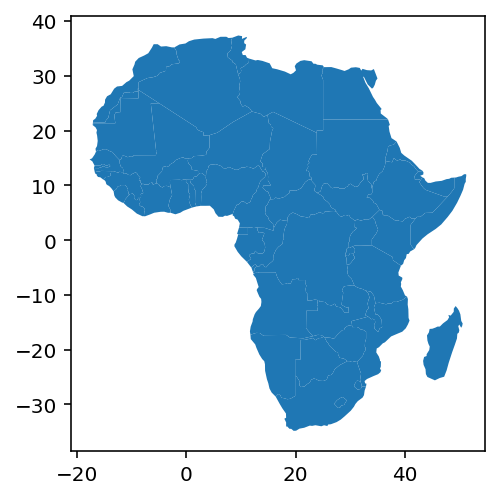

In [46]:
africa.plot()

In [47]:
cities['geometry'] = cities.buffer(2)

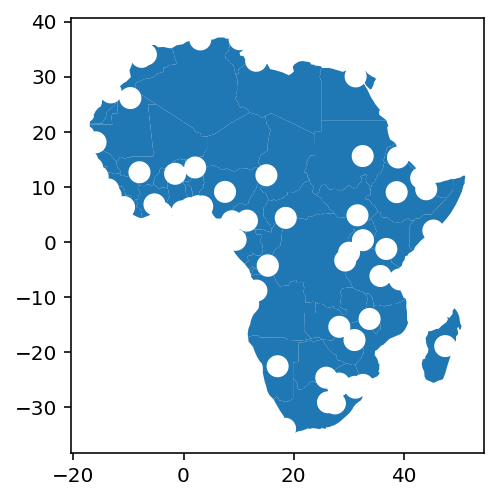

In [48]:
geopandas.overlay(africa, cities, how='difference').plot()

<div class="alert alert-info" style="font-size:120%">
<b>REMEMBER</b> <br>

<ul>
  <li>**Spatial join**: transfer attributes from one dataframe to another based on the spatial relationship</li>
  <li>**Spatial overlay**: construct new geometries based on spatial operation between both dataframes (and combining attributes of both dataframes)</li>
</ul>

</div>